In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.ndimage import median_filter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [4]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456645.083
heaterOn 2014/06/13    03:05  253.0 2456

In [5]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [6]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)

# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True



t171 = ts[m171 & noPinholes & ~withinBakeout]
t195 = ts[m195 & noPinholes & ~withinBakeout]
t284 = ts[m284 & noPinholes & ~withinBakeout]
t304 = ts[m304 & noPinholes & ~withinBakeout]

f171 = fs[m171 & noPinholes & ~withinBakeout]
f195 = fs[m195 & noPinholes & ~withinBakeout]
f284 = fs[m284 & noPinholes & ~withinBakeout]
f304 = fs[m304 & noPinholes & ~withinBakeout]

u171 = us[m171 & noPinholes & ~withinBakeout]
u195 = us[m195 & noPinholes & ~withinBakeout]
u284 = us[m284 & noPinholes & ~withinBakeout]
u304 = us[m304 & noPinholes & ~withinBakeout]

# basic outlier rejection

movingMed = median_filter(f171, size=51, mode='reflect')
outlierMask = (f171-movingMed > 1500*u171) | (f171 < 1.e7)
f171[outlierMask] = np.nan
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t171, f171, yerr=u171,marker='.', color='k',elinewidth=1,capsize=0,ls='None',zorder=1)
ax.plot(t171, movingMed, 'b.',zorder=2)
ax.plot(t171[outlierMask], f171[outlierMask],'r.',zorder=3)
#ax.set_ylim(0.,2.e8)
plt.show()
"""
movingMed = median_filter(f195, size=51, mode='reflect')
outlierMask = (f195-movingMed > 1500*u195) | (f195 < 1.e7)
f195[outlierMask] = np.nan
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t195, f195, yerr=u195,marker='.', color='k',elinewidth=1,capsize=0,ls='None',zorder=1)
ax.plot(t195, movingMed, 'b.',zorder=2)
ax.plot(t195[outlierMask], f195[outlierMask],'r.',zorder=3)
#ax.set_ylim(0.,2.e8)
plt.show()
"""
movingMed = median_filter(f284, size=51, mode='reflect')
outlierMask = (f284-movingMed > 1500*u284) | (f284 < 1.e6)
f284[outlierMask] = np.nan
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t284, f284, yerr=u284,marker='.', color='k',elinewidth=1,capsize=0,ls='None',zorder=1)
ax.plot(t284, movingMed, 'b.',zorder=2)
ax.plot(t284[outlierMask], f284[outlierMask],'r.',zorder=3)
#ax.set_ylim(0.,3.e7)
plt.show()
"""
movingMed = median_filter(f304, size=51, mode='reflect')
outlierMask = (f304-movingMed > 1500*u304) | (f304 < 5.e6)
f304[outlierMask] = np.nan
"""
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, f304, yerr=u304,marker='.', color='k',elinewidth=1,capsize=0,ls='None',zorder=1)
ax.plot(t304, movingMed, 'b.',zorder=2)
ax.plot(t304[outlierMask], f304[outlierMask],'r.',zorder=3)
#ax.set_ylim(0.,1.e8)
plt.show()
"""


148114320263.0 m
0.9900830778535941 AU
149597870700.0


"\nfig, ax = plt.subplots(1,1,figsize=(16,6))\nax.errorbar(t304, f304, yerr=u304,marker='.', color='k',elinewidth=1,capsize=0,ls='None',zorder=1)\nax.plot(t304, movingMed, 'b.',zorder=2)\nax.plot(t304[outlierMask], f304[outlierMask],'r.',zorder=3)\n#ax.set_ylim(0.,1.e8)\nplt.show()\n"

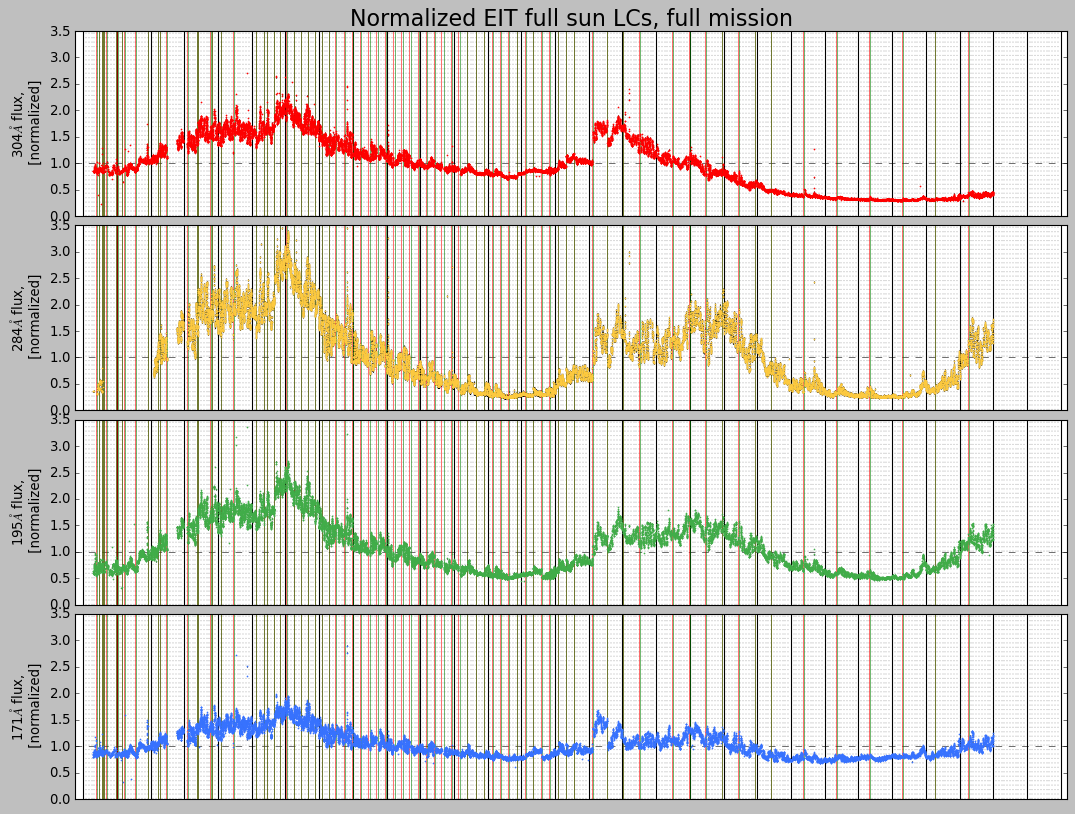

In [7]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,12))

tarr = [t304, t284, t195, t171]
farr = [f304, f284, f195, f171]
uarr = [u304, u284, u195, u171]
labels=['304','284','195','171']

for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    #axes[3].text(jan1_thisyear + 180., 0.1, str(y),horizontalalignment='center',fontsize=10)

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)

    
for i, ax in enumerate(axes):
   
    fluxnorm = np.median(farr[i][~np.isnan(farr[i])])

    plotcolor = cs[i]
    
    axes[i].errorbar(tarr[i], farr[i]/fluxnorm, yerr=uarr[i]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k')
    #axes[i].plot(tarr[i], 0.3*np.ones_like(tarr[i]), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(labels[i],len(tarr[i])))
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(labels[i]))

for ax in axes:
    ax.set_xticks([])

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,3.5)
    ax.set_xlim(2450000, 2460750)
    #ax.set_xlim(2455250,2455750)

    
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    
axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
plt.subplots_adjust(hspace=0.05)
#plt.show()
plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")

# Evaluate whether the ratio of (first flux after bakeout)/(last flux before bakeout) is the same across the four bands.

In [8]:
def bakeoutFluxRatio(t, f, bakeoutStart, bakeoutEnd):
    beforeBakeout = (t < bakeoutStart)
    lastTimeBeforeBakeout = t[beforeBakeout][-1]
    lastTimeIdxBeforeBakeout = np.arange(len(t))[beforeBakeout][-1]

    #fBefore = np.median(f[lastTimeIdxBeforeBakeout-3:lastTimeIdxBeforeBakeout])
    fBefore = f[lastTimeIdxBeforeBakeout]

    afterBakeout = (t > bakeoutEnd)
    firstTimeAfterBakeout = t[afterBakeout][0]
    firstTimeIdxAfterBakeout = np.arange(len(t))[afterBakeout][0]

    #fAfter = np.median(f[firstTimeIdxAfterBakeout:firstTimeIdxAfterBakeout+3])
    fAfter = f[firstTimeIdxAfterBakeout]

    fRatio = fAfter/fBefore
    
    return lastTimeIdxBeforeBakeout, firstTimeIdxAfterBakeout, fRatio

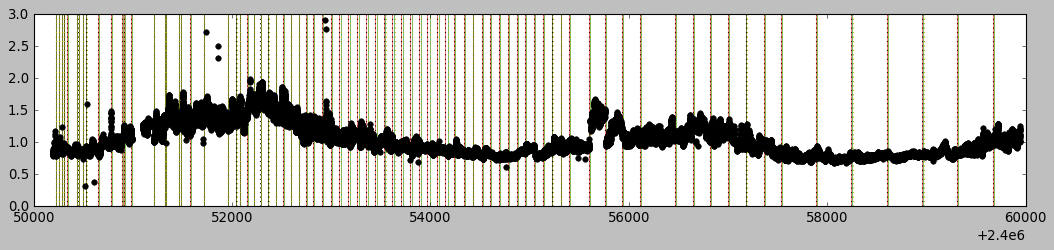

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,3))

tarr = t171
farr = f171
uarr = u171
fluxnorm = np.median(farr[~np.isnan(farr)])

ax.errorbar(tarr, farr/fluxnorm, yerr=uarr/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=10,c='k',ecolor='k')
for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
    ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

    lastIdxBefore, firstIdxAfter, fRatio = bakeoutFluxRatio(tarr, farr, bakeoutStart = heaterOn[i]['jd'],bakeoutEnd=heaterOff[i]['jd'])
    ax.axvline(tarr[lastIdxBefore],color='k',linestyle=':')
    ax.axvline(tarr[firstIdxAfter],color='y',linestyle=':')

#ax.set_xlim(2454000,2457000)
#ax.set_ylim(0.,10)
plt.show()

In [10]:
#flux ratios
fr171 = np.zeros(81)
fr195 = np.zeros(81)
fr284 = np.zeros(81)
fr304 = np.zeros(81)

for j in range(81):
    first,last,fr304_j = bakeoutFluxRatio(t304, f304, bakeoutStart = heaterOn[j]['jd'],bakeoutEnd=heaterOff[j]['jd'])
    fr304[j] = fr304_j
    first,last,fr284_j = bakeoutFluxRatio(t284, f284, bakeoutStart = heaterOn[j]['jd'],bakeoutEnd=heaterOff[j]['jd'])
    fr284[j] = fr284_j
    first,last,fr195_j = bakeoutFluxRatio(t195, f195, bakeoutStart = heaterOn[j]['jd'],bakeoutEnd=heaterOff[j]['jd'])
    fr195[j] = fr195_j
    first,last,fr171_j = bakeoutFluxRatio(t171, f171, bakeoutStart = heaterOn[j]['jd'],bakeoutEnd=heaterOff[j]['jd'])
    fr171[j] = fr171_j

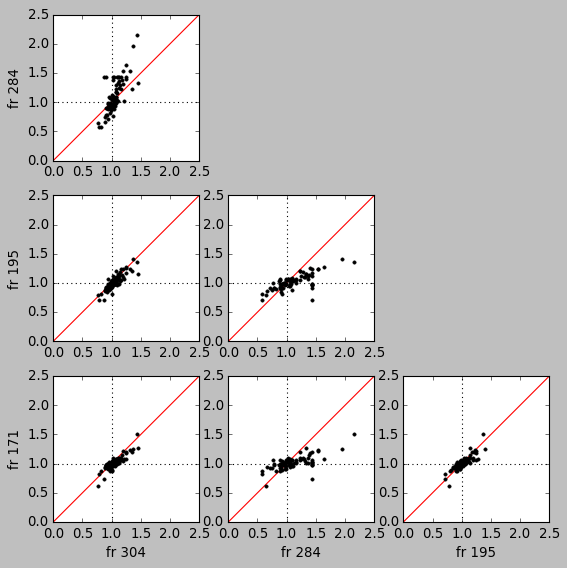

In [11]:
fig, axes = plt.subplots(3,3,figsize=(8,8))

axes[0,0].plot(fr304,fr284,'k.',zorder=2)
axes[1,0].plot(fr304,fr195,'k.',zorder=2)
axes[2,0].plot(fr304,fr171,'k.',zorder=2)

axes[1,1].plot(fr284,fr195,'k.',zorder=2)
axes[2,1].plot(fr284,fr171,'k.',zorder=2)

axes[2,2].plot(fr195,fr171,'k.',zorder=2)

axes[2,0].set_xlabel("fr 304")
axes[0,0].set_ylabel("fr 284")

axes[1,0].set_ylabel("fr 195")
axes[2,0].set_ylabel("fr 171")

axes[2,1].set_xlabel("fr 284")
axes[2,2].set_xlabel("fr 195")

for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.set_xlim(0,2.5)
    ax.set_ylim(0,2.5)
    ax.plot(np.linspace(0,2.5,10),np.linspace(0,2.5,10),'r-',zorder=1)
    ax.axhline(1.0,ls=":",color='k',zorder=1)
    ax.axvline(1.0,ls=":",color='k',zorder=1)
    ax.set_aspect("equal")

plt.show()